In [1]:
from ouroath.hdfsproxy import HdfsProxy
hdfs = HdfsProxy("bassniumblue-nn1-pxy.blue.ygrid.yahoo.com")
with open('/home/yonatang/ephemeral_drive/102flowers.tgz', 'wb+') as f:
        f.write(hdfs.stream('102flowers.tgz').read())

In [2]:
!pip install pytorch-lightning

Looking in indexes: https://edge.artifactory.ouroath.com:4443/artifactory/api/pypi/pypi-mirror/simple
     |████████████████████████████████| 696 kB 2.4 MB/s eta 0:00:01
     |████████████████████████████████| 98 kB 2.0 MB/s eta 0:00:011
     |████████████████████████████████| 269 kB 2.3 MB/s eta 0:00:01
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44621 sha256=ba72b1af1dcf57db394e8bd225b1058bcee0c1f4226ce2e75382bedf554e7d82
  Stored in directory: /home/default/.cache/pip/wheels/6a/35/b6/279c17117e4e12b2fd523cd205c2e80443f2417b77c93a8a25
Successfully built PyYAML
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 5.4.1
    Uninstalling PyYAML-5.4.1:
      Successfully uninstalled PyYAML-5.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ludwig 0.3.3 requires kaggle, which is not installed.
ludwig 0.3.

In [2]:
!unzip ~/ephemeral_drive/flickr8k.zip -d ~/ephemeral_drive/

Archive:  /home/yonatang/ephemeral_drive/flickr8k.zip
  inflating: /home/yonatang/ephemeral_drive/Images/1000268201_693b08cb0e.jpg  
  inflating: /home/yonatang/ephemeral_drive/Images/1001773457_577c3a7d70.jpg  
  inflating: /home/yonatang/ephemeral_drive/Images/1002674143_1b742ab4b8.jpg  
  inflating: /home/yonatang/ephemeral_drive/Images/1003163366_44323f5815.jpg  
  inflating: /home/yonatang/ephemeral_drive/Images/1007129816_e794419615.jpg  
  inflating: /home/yonatang/ephemeral_drive/Images/1007320043_627395c3d8.jpg  
  inflating: /home/yonatang/ephemeral_drive/Images/1009434119_febe49276a.jpg  
  inflating: /home/yonatang/ephemeral_drive/Images/1012212859_01547e3f17.jpg  
  inflating: /home/yonatang/ephemeral_drive/Images/1015118661_980735411b.jpg  
  inflating: /home/yonatang/ephemeral_drive/Images/1015584366_dfcec3c85a.jpg  
  inflating: /home/yonatang/ephemeral_drive/Images/101654506_8eb26cfb60.jpg  
  inflating: /home/yonatang/ephemeral_drive/Images/101669240_b2d3e7f17b.jpg  


In [2]:

from torchvision import datasets, models, transforms,utils
import pandas as pd
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import torch.nn as nn
import torch as torch
import matplotlib.pyplot as plt
import torchvision as torchvision
import time
from tqdm.notebook import tqdm
import pytorch_lightning as pl
import torch.nn.functional as F
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import requests


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [14]:
def mymshow(img, std=(0.5, 0.5, 0.5), mean=(0.5, 0.5, 0.5), fig_size=[8,8],xlabel=None):
    img = img.permute(1,2,0).cpu()
#    img = img * torch.tensor(std) + torch.tensor(mean)
    img = torch.clip(img,0,1)
    fig,ax = plt.subplots()
    fig.set_size_inches(*fig_size)
    ax.imshow(img)
    ax.set_xlabel(xlabel,fontsize=16)
    plt.show()

In [15]:
class DamagedFlickr(Dataset):
    def __init__(self, path, transform, damaged_transforms, hflip=False):
        self.transform = transform   
        self.damaged_transforms = damaged_transforms
        path = Path(path)
        self.files = [i for i in path.glob('**/*') if i.is_file()]
        
    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        image = self.transform(Image.open(self.files[idx]))
        damaged = self.damaged_transforms(Image.open(self.files[idx]))
        return damaged,image

In [16]:
def get_bw_transforms(img_size = (256,256)):
       
    transform = transforms.Compose([transforms.Resize(img_size),
                                    transforms.ToTensor(),                                    
#                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                   ])

    damaged_transform = transforms.Compose([transforms.Resize(img_size),
                                            transforms.Grayscale(),
                                            transforms.ToTensor(),                                           
#                                            transforms.Normalize(0.5,0.5),
#                                            transforms.Lambda(lambda x:x[0:1,:,:])
                                           ])
    return transform, damaged_transform

In [17]:
def gen_datasets(img_size = (256,256)):
    images = '/home/yonatang/ephemeral_drive/Images/'
    dataset = DamagedFlickr(images,*get_bw_transforms(img_size))
    train_len = 7000
    val_len = len(dataset)-train_len
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_len, val_len],generator=torch.Generator().manual_seed(42))
    return train_dataset,val_dataset

In [18]:
train_dataset,val_dataset = gen_datasets((128,128))

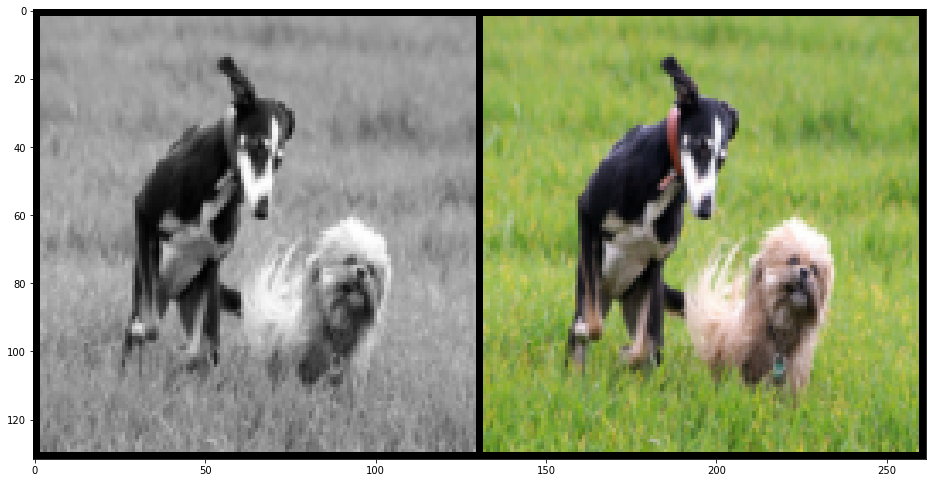

In [19]:
i=219
x,y = train_dataset[i]
mymshow(torchvision.utils.make_grid(torch.stack([torch.cat([x,x,x]),y],dim=0),nrow=2),fig_size=(16,16)) 

In [26]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding,):
        super().__init__() 
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),                        
            nn.ReLU(),       
#            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            nn.ReLU(),
#            nn.BatchNorm2d(out_channels),

        )
        
    def forward(self,x):
        return self.layers(x)
    
    
class Contract(nn.Module):
    def __init__(self,in_channels, out_channels, kernel_size, padding):
        super().__init__()
        self.layers = DoubleConv(in_channels, out_channels, kernel_size, padding)
        self.downsample = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
    def forward(self,x):
        y = self.layers(x)
        return y,self.downsample(y)


class Expand(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, dropout=0):
        super().__init__()
        self.upsample = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.layers = DoubleConv(in_channels, out_channels, kernel_size, padding)
        
    def forward(self, a, x):
        x = self.upsample(x)
        return self.layers(torch.cat([a,x],dim=1))

In [27]:
class Unet(nn.Module):
    def __init__(self, start_features=64):
        super().__init__()
        
        input_channels=1
        output_channels=3
        
        self.contract_1 = Contract(input_channels,start_features,5,2)
        self.contract_2 = Contract(start_features,start_features*2,3,1)
        self.contract_3 = Contract(start_features*2,start_features*4,3,1)
        self.contract_4 = Contract(start_features*4,start_features*8,3,1)
    
        self.mid_layers = DoubleConv(start_features*8, start_features*16, 3, 1)
        
        self.expand_1 = Expand(start_features*16,start_features*8,3,1)
        self.expand_2 = Expand(start_features*8,start_features*4,3,1)
        self.expand_3 = Expand(start_features*4,start_features*2,3,1)
        self.expand_4 = Expand(start_features*2,start_features,3,1)
        
        self.final = nn.Sequential(nn.Conv2d(start_features, output_channels, 1, stride=1, padding=0))
                
    def forward(self, image):
        a1,a1_pooled = self.contract_1(image)        
        a2,a2_pooled = self.contract_2(a1_pooled)
        a3,a3_pooled = self.contract_3(a2_pooled)
        a4,a4_pooled = self.contract_4(a3_pooled)
        
        mid = self.mid_layers(a4_pooled)
        
        b1 = self.expand_1(a4,mid)
        b2 = self.expand_2(a3,b1)
        b3 = self.expand_3(a2,b2)
        b4 = self.expand_4(a1,b3)
        
        final = self.final(b4)
        return final

In [28]:
class NNet(pl.LightningModule):
  
    def __init__(self,start_features=64):
        super().__init__()
        self.unet = Unet(start_features)
        
        self.train_mse = pl.metrics.MeanSquaredError()
        self.val_mse = pl.metrics.MeanSquaredError()
    
    def forward(self, x):
        return self.unet(x)
    
    def training_step(self, batch, batch_idx):
        x,y = batch
        yhat = self(x)           
        loss = F.mse_loss(yhat,y)
        
        self.train_mse(yhat, y)
        self.log('train_loss', loss)
        return loss
    
    def training_epoch_end(self, training_step_outputs):
        self.logger.experiment.add_scalars("epoch_losses", {"train_loss": self.train_mse.compute()},
                                           global_step=self.current_epoch)
    
    def validation_step(self, batch, batch_idx):
        x,y = batch
        yhat = self(x)   
        loss = F.mse_loss(yhat,y)
        
        self.val_mse(yhat, y)  
        self.log('val_loss', loss)
        return loss
     
    def validation_epoch_end(self, validation_step_outputs):
        self.logger.experiment.add_scalars("epoch_losses", {"val_loss": self.val_mse.compute()},
                                           global_step=self.current_epoch)
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)
        return optimizer

In [29]:
model = NNet(start_features=32).to(device)

In [30]:
x = torch.randn(2,1,128,128,device=device)
y = model(x)

In [5]:
resnet = torchvision.models.resnet34(pretrained=False).to(device)

In [6]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [43]:
# small utility function I once made to print nn layer input->output
# like keras model.summary()
# I can debug conv layers input and output instead of calculating by hand
def hook(module, input, output):
    if type(module) != nn.Sequential:
        print(f'{module.__class__.__name__:<15} {str([*input[0].shape]):<20} --> {[*(output[1].shape if len(output)==2 else output.shape)]}')

def print_layers(module, input_shape):
    handles = []
    module.apply(lambda l: handles.append(l.register_forward_hook(hook)));
    module(torch.randn(*input_shape,device=device));
    [h.remove() for h in handles]

In [44]:
print_layers(resnet,[2,3,128,128])

Conv2d          [2, 3, 128, 128]     --> [64, 64, 64]
Conv2d          [2, 3, 128, 128]     --> [64, 64, 64]
Conv2d          [2, 3, 128, 128]     --> [64, 64, 64]
BatchNorm2d     [2, 64, 64, 64]      --> [64, 64, 64]
BatchNorm2d     [2, 64, 64, 64]      --> [64, 64, 64]
BatchNorm2d     [2, 64, 64, 64]      --> [64, 64, 64]
ReLU            [2, 64, 64, 64]      --> [64, 64, 64]
ReLU            [2, 64, 64, 64]      --> [64, 64, 64]
ReLU            [2, 64, 64, 64]      --> [64, 64, 64]
MaxPool2d       [2, 64, 64, 64]      --> [64, 32, 32]
MaxPool2d       [2, 64, 64, 64]      --> [64, 32, 32]
MaxPool2d       [2, 64, 64, 64]      --> [64, 32, 32]
Conv2d          [2, 64, 32, 32]      --> [64, 32, 32]
Conv2d          [2, 64, 32, 32]      --> [64, 32, 32]
Conv2d          [2, 64, 32, 32]      --> [64, 32, 32]
BatchNorm2d     [2, 64, 32, 32]      --> [64, 32, 32]
BatchNorm2d     [2, 64, 32, 32]      --> [64, 32, 32]
BatchNorm2d     [2, 64, 32, 32]      --> [64, 32, 32]
ReLU            [2, 64, 32, 

RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 31.75 GiB total capacity; 269.21 MiB already allocated; 3.44 MiB free; 296.00 MiB reserved in total by PyTorch)

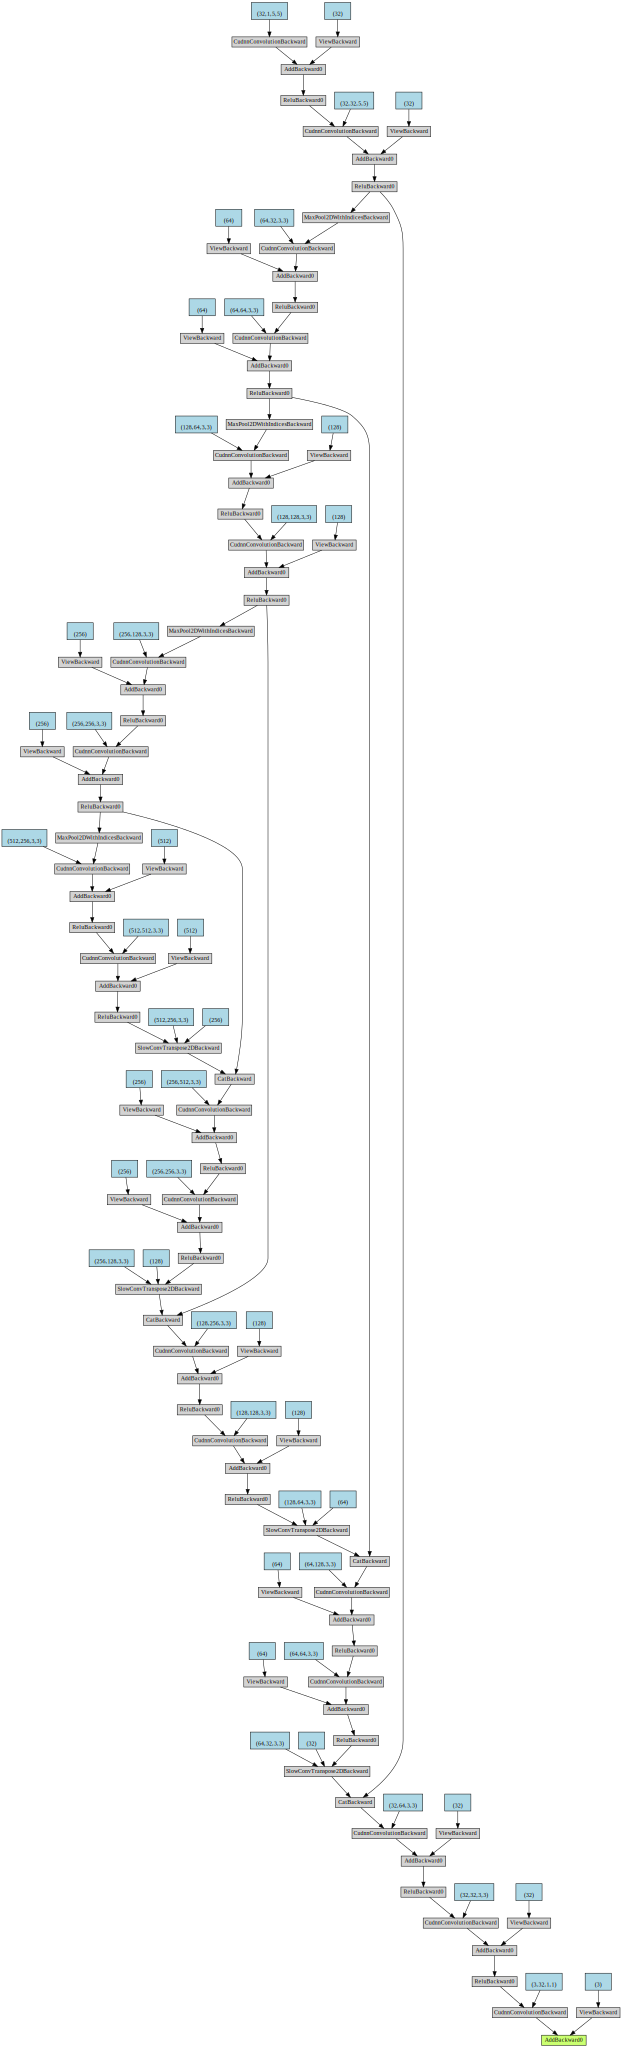

In [31]:
from torchviz import make_dot
make_dot(y)

In [242]:
train_dataset,val_dataset = gen_datasets((64,64))
train_dl = DataLoader(
        train_dataset,
        batch_size=16,
        num_workers=4,
        pin_memory=False,
        shuffle=True)

val_dl = DataLoader(
        val_dataset,
        batch_size=16,
        num_workers=4,
        pin_memory=False,
        shuffle=False) 

In [244]:
#lr_monitor = LearningRateMonitor(logging_interval='step')

#logger = pl.loggers.TensorBoardLogger('viz_logs_correct_datasets', name=experiment_name)
# trainer = pl.Trainer(gpus=1, 
#                      progress_bar_refresh_rate=20,
#                      max_epochs=50,
#                      logger=logger,
#                      precision=16,
#                      callbacks=[EarlyStopping(monitor='val_loss',patience=5,mode='min'),
#                                 checkpoint_callback,
#                                 lr_monitor],) 


trainer = pl.Trainer(gpus=1,
                     max_epochs=20,
                     precision=16,
                     checkpoint_callback=False
#                     callbacks=[EarlyStopping(monitor='val_loss',patience=3,mode='min')]
                    )

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.


In [245]:
trainer.fit(model, train_dl, val_dl)


  | Name      | Type             | Params
-----------------------------------------------
0 | unet      | Unet             | 34.6 M
1 | train_mse | MeanSquaredError | 0     
2 | val_mse   | MeanSquaredError | 0     
-----------------------------------------------
34.6 M    Trainable params
0         Non-trainable params
34.6 M    Total params


1

In [246]:
trainer = pl.Trainer(gpus=1,
                     max_epochs=10,
                     precision=16,
                     checkpoint_callback=False
#                     callbacks=[EarlyStopping(monitor='val_loss',patience=3,mode='min')]
                    )
train_dataset,val_dataset = gen_datasets((128,128))
train_dl = DataLoader(
        train_dataset,
        batch_size=16,
        num_workers=4,
        pin_memory=False,
        shuffle=True)

val_dl = DataLoader(
        val_dataset,
        batch_size=16,
        num_workers=4,
        pin_memory=False,
        shuffle=False) 

trainer.fit(model, train_dl, val_dl)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.

  | Name      | Type             | Params
-----------------------------------------------
0 | unet      | Unet             | 34.6 M
1 | train_mse | MeanSquaredError | 0     
2 | val_mse   | MeanSquaredError | 0     
-----------------------------------------------
34.6 M    Trainable params
0         Non-trainable params
34.6 M    Total params


1

In [ ]:
trainer = pl.Trainer(gpus=1,
                     max_epochs=70,
                     precision=16,
                     checkpoint_callback=False
#                     callbacks=[EarlyStopping(monitor='val_loss',patience=3,mode='min')]
                    )
train_dataset,val_dataset = gen_datasets((256,256))
train_dl = DataLoader(
        train_dataset,
        batch_size=16,
        num_workers=4,
        pin_memory=False,
        shuffle=True)

val_dl = DataLoader(
        val_dataset,
        batch_size=16,
        num_workers=4,
        pin_memory=False,
        shuffle=False) 

trainer.fit(model, train_dl, val_dl)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.

  | Name      | Type             | Params
-----------------------------------------------
0 | unet      | Unet             | 34.6 M
1 | train_mse | MeanSquaredError | 0     
2 | val_mse   | MeanSquaredError | 0     
-----------------------------------------------
34.6 M    Trainable params
0         Non-trainable params
34.6 M    Total params


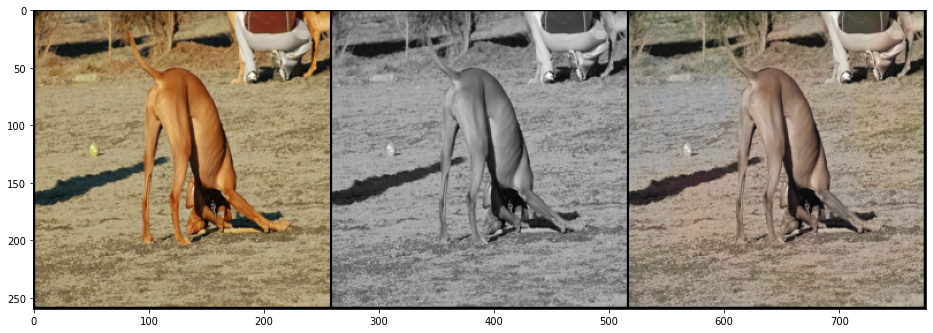

In [230]:
x,y = val_dataset[330]
model = model.to(device)
model.eval()
yhat =  model(x.unsqueeze(0).to(device)).squeeze(0).cpu().detach()
mymshow(torchvision.utils.make_grid(torch.stack([y,torch.cat([x,x,x]),yhat],dim=0),nrow=3),fig_size=(16,16))